# Introduction

In this lab we will learn how to use a digital LLRF system as an oscilloscope and a spectrum analyzer by directly recording the raw ADC waveforms. We will also learn how to characterize the ADC itself, and compare against manufacture's specifications for testing the system's performance.

## Firmware frequency setting

| Frequency    | Derivation  | Value  | Unit |
|--------------|-------------|--------|------|
| f_MO         |             | 480    | MHz  |
| f_IF         | f_MO/24     | 20     | MHz  |
| f_LO         | f_MO - f_IF | 460    | MHz  |
| f_CLK        | f_LO / 4    | 115    | MHz  |
| f_IF / f_CLK |             | 4 / 23 |      |

## Glossary

* f_MO
: Master Oscillator frequency, equals to the frequency of operation, or cavity RF frequency.

* f_IF
: [Intermediate Frequency](https://en.wikipedia.org/wiki/Intermediate_frequency). RF signal processing is often performed at a frequency significantly below the frequency of operation. Signal at IF is typically produced 
by a [superheterodyne receiver](https://en.wikipedia.org/wiki/Heterodyne).

* f_LO
: [Local Oscillator](https://en.wikipedia.org/wiki/Local_oscillator) frequency.

* f_CLK
: ADC / DAC sampling clock, which is equal to the clock frequency of DSP logic.

* ADC
: [Analog-to-digital converter](https://en.wikipedia.org/wiki/Analog-to-digital_converter), an electronics device that converts continuous signals to discrete digital numbers. We use Analog Devices [AD9643](https://www.analog.com/media/en/technical-documentation/data-sheets/ad9653.pdf) in [Zest](https://github.com/BerkeleyLab/Zest) digitizer board in the LLRF system.


## Hardware setup
![hardware setup](uspas_llrf_adc.png)

## Firmware and software setup
* Configure FPGA chassis using the provided `marble_zest_top_uspas.bit`;
* Start EPICS IOC on the connected laptop computer;

# Exercises

## Measure 20 MHz signal

Set the signal generator to 20.00 MHz, 0 dBm.
Connect to one of the ADC channels on the rear panel of the LLRF chassis.

The raw ADC data is buffered in a memory block, which can be read out. 
The EPICS PV name is `USPAS:LLRF:reg_adc?_buf_RBV` where `?` is the channel number in `[0,7]`, and total length is 4096 per channel.
For example, to read the first 10 samples through `caget`:
```bash
$ caget -# 10 USPAS:LLRF:reg_adc0_buf_RBV
USPAS:LLRF:reg_adc0_buf_RBV 10 -42 -51 -49 -50 -44 -48 -50 -47 -45 -47
```

The following example uses [`pyepics`](https://github.com/pyepics/pyepics) for EPICS IO.

Capture the ADC waveform of each channel using the following example.
Plot the data with horizontal axis in time and vertical axis in ADC counts.

Example: recording `ADC1` data, which has no signal connected:

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
from epics import PV

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['font.size'] = 8

* Note the channel number inversion due to chassis design;
* the ADC waveforms are from an EPICS IOC which is updating at 2 Hz rate;

In [28]:
pvs = {
    f'adc{8-i}': PV(f'USPAS:LLRF:reg_adc{i}_buf_RBV')
    for i in range(8)}
adc_dat = pvs['adc8'].value

[ 23817  17884  16899 ... -18863  -5873  24564]


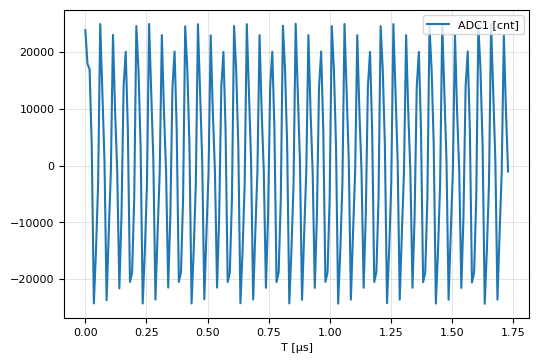

In [29]:
fs = 480 * 23 / 24 / 4  # MHz
t = np.arange(len(adc_dat)) / fs  # µs

df = pd.DataFrame({
    'T [µs]': np.arange(len(adc_dat)) / fs,
    'ADC1 [cnt]': adc_dat})
df[:200].plot(x='T [µs]');

## Using LLRF as a spectrum analyzer

Plot the full power spectrum of the recorded data in log-log scale.
Use the unit of `dBFS`, which is the power relative to the ADC Full Scale. The AD9653 ADC has 16-bit resolution.

Hint: use either `numpy.fft` or `scipy.signal.periodogram`, pay attention to scaling, RMS amplitude and use a flattop window.

Answer the following questions:
1. What's the frequency resolution of the power spectrum?
2. For the connected channel, what's the measured peak frequency?
3. Compare the plotted spectrum with Figure 8 on page 14 in [AD9653 datasheet](https://www.analog.com/media/en/technical-documentation/data-sheets/ad9653.pdf), does the ADC function as expected in terms of noise floor and Signal Noise Ratio (SNR)?


## Finding ADC full scale

Now let's determine the full-scale sensitivity of the ADC in dBm. To do
that, increase the output of the generator in small steps (0.1 dB). When you
reach and exceed the full scale, harmonic distortion level will rise
significantly. Do not exceed +10 dBm.
Reduce the source level just below that point - that is your full-scale
sensitivity. Record that level.


## Harmonic distortion

Observe additional peaks in the spectrum other than the fundamental frequency. Record the frequency and amplitudes of the three largest peaks (including the fundamental), label them with harmonic number.


## Measure channel-to-channel isolation

Plot all ADC spectrums together where only one channel has near full scale input at 20MHz.
Measure channel-to-channel isolation (in dB) matrix.

For example, here is a measured result for the LBNL ALS-U LLRF system, at RF frequency of 499.60 MHz, except the last two channels which are direct sampling at $f_\text{IF} = 41.67$ MHz).

![alsu_isoluation_matrix](llrf1_isolation_matrix.png)

![alsu_isoluation](llrf1_isolation.png)